In [1]:
import os 
import os.path as osp
import numpy as np
import pandas as pd 
import torch as th 
from matplotlib import pyplot as plt 
import sys 
from torch.utils.data import DataLoader

sys.path.append("/mnt/e/Personal/Samarth/repository/RGB_to_3D_conversion/src")
from depth_model.model import PTModel
from data_loader.data_creation import CreateDataset
from utils.data_transforms import pre_process

print(th.cuda.is_available())
device = 'cuda' if th.cuda.is_available() else 'cpu'

True


In [ ]:
depth_model = PTModel().to(device)
checkpoint = th.load("../model/depth_model.ckpt")
depth_model.load_state_dict(checkpoint)
depth_model.eval()

### Load Test  Images 

In [3]:
data_path = "/mnt/e/Personal/Samarth/repository/RGB_to_3D_conversion/Data"
val_df = pd.read_csv(os.path.join(data_path, 'data/nyu2_test.csv'))
val_df.columns = ['RGB_images', 'Depth_images']
val_df.head()

,RGB_images,Depth_images
0,data/nyu2_test/00001_colors.png,data/nyu2_test/00001_depth.png
1,data/nyu2_test/00008_colors.png,data/nyu2_test/00008_depth.png
2,data/nyu2_test/00013_colors.png,data/nyu2_test/00013_depth.png
3,data/nyu2_test/00014_colors.png,data/nyu2_test/00014_depth.png
4,data/nyu2_test/00015_colors.png,data/nyu2_test/00015_depth.png


In [4]:
val_rgb_files = [osp.join(data_path, filename) for filename in val_df['RGB_images'].to_list()]
val_depth_files = [osp.join(data_path, filename) for filename in val_df['Depth_images'].to_list()]

valid_dataset = CreateDataset(rgb_files=val_rgb_files,
                                depth_files=val_depth_files,
                                transform=None,
                                task='validation',
                                process_image=pre_process())
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=1)

### Predict and Visualize 

In [5]:
def to_multichannel(i):
    if i.shape[2] == 3: return i
    i = i[:,:,0]
    return np.stack((i,i,i), axis=2)

def tensor_to_numpy_image(image,rgb=True):
    image = image.permute(1,0,2,3).squeeze(axis=0).cpu().detach().numpy()
    if rgb:
        image = image.squeeze(axis=1)
        return np.array(image.transpose(1, 2, 0)*255, dtype=np.uint8) 
    else:
        return image.squeeze(axis=0)

def DepthNorm(x, maxDepth):
    return maxDepth / x

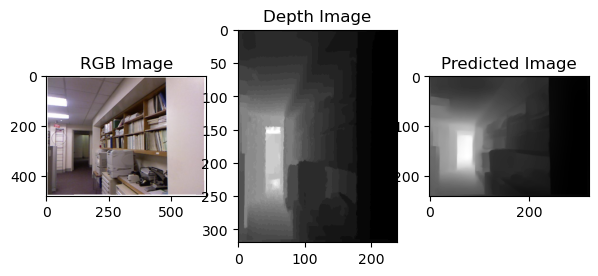

In [6]:
plt.figure(figsize=(7,15))

for i, sample_batch in enumerate(valid_loader):
    image = sample_batch['image'].to(device)
    depth = sample_batch['depth'].to(device)
    
    y_pred = depth_model(sample_batch['image'].to(device))
    y_pred = tensor_to_numpy_image(y_pred,rgb=False)
    y_pred = DepthNorm(y_pred,0.05)*255
    depth_image = tensor_to_numpy_image(depth,rgb=False)
    resize_image =  tensor_to_numpy_image(image) # , shape, preserve_range=True, mode='reflect', anti_aliasing=True )
    
    plt.subplot(1,3,1)
    plt.title("RGB Image")
    plt.imshow(resize_image)
    
    plt.subplot(1,3,2)
    plt.title("Depth Image")
    plt.imshow(depth_image,cmap='gray')

    plt.subplot(1,3,3)
    plt.title("Predicted Image")
    plt.imshow(y_pred,cmap='gray')  

    # print(f"Image resolution: {y_pred.shape}")
    # print(f"Data type: {y_pred.dtype}")
    # print(f"Min value: {np.min(y_pred)}")
    # print(f"Max value: {np.max(y_pred)}")
    if i == 4:
        break
    

### Fine Tune Model

In [ ]:
# save layer names
layer_names = []
for idx, (name, param) in enumerate(depth_model.named_parameters()):
    layer_names.append(name)
# Getting the depth layers for decoder 
# reverse layers
layer_names.reverse()
print(layer_names[0:20])
            

### Retrain the Model with Dataset provided by the Assignement with some changes 

## Fine Tune with LR 
The key idea is to gradually reduce the learning rate when going deeper into the network. The first layers should already have a pretty good understanding of general domain-agnostic patterns after pre-training. In a computer vision setting, the first layers may have learned to distinguish simple shapes and edges; in natural language processing, the first layers may be responsible for general word relationships. We don't want to update parameters on the first layers too much, so it makes sense to reduce the corresponding learning rates. In contrast, we would like to set a higher learning rate for the final layers, especially for the fully-connected classifier part of the network. Those layers usually focus on domain-specific information and need to be trained on new data.

### Fine Tune with Augmetations 
Adding Augmentations to generalize the Brightness and contrast in the image , though the environment seems restricted , but still it is a good practice to add randomize brightness and contrast. Adding Rotations and Gaussian blur is another augmentation technique that helped to improve the loss.

In [ ]:
import albumentations as album

def fine_tune(pretrined_model):
    # save layer names
    layer_names = []
    for idx, (name, param) in enumerate(pretrined_model.named_parameters()):
        layer_names.append(name)
    # Getting the depth layers for decoder 
    # reverse layers
    layer_names.reverse()

    # learning rate
    lr      = 1e-2
    lr_mult = 0.9
    # placeholder
    parameters = []

    # store params & learning rates
    for idx, name in enumerate(layer_names):
        # append layer parameters
        parameters += [{'params': [p for n, p in pretrined_model.named_parameters() if n == name and p.requires_grad],
                        'lr':     lr}]
        # update learning rate
        lr *= lr_mult
    return parameters

def get_training_augmentation():
    train_transform = [
        album.OneOf(
            [
                album.RandomBrightnessContrast(p=1),
                album.ChannelShuffle(p=1),
                album.Sharpen(p=1),
                album.SafeRotate(p=1)
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)

fine_tune = False
if fine_tune :
    checkpoint = th.load("../model/depth_model.ckpt") 
    depth_model.load_state_dict(checkpoint)
    parameters  = fine_tune(pretrined_model=depth_model)
    print(th.optim.Adam(parameters))

## Run the train pipeline thereafter 

# Run the train.py with --pretrained argument from terminal 
# os.system("python train_assignment_data.py --path ../Data/Assignment_data/360_scans --pretrained ../model/child_depth_model.ckpt --model_name child_depth_model --outdir /content/model --epochs 40 ")

In [ ]:
import torch
from PIL import Image

fine_tune_model_checkpoint = "/mnt/e/Personal/Samarth/repository/RGB_to_3D_conversion/model/child_depth_model.ckpt"
fine_tune_depth_model = PTModel().float().to(device)

fine_tune_depth_model.load_state_dict(torch.load(fine_tune_model_checkpoint))

### Run Inference on Assignment images 

In [9]:
from glob import glob 
import sys 
sys.path.append("/mnt/e/Personal/Samarth/repository/RGB_to_3D_conversion/src/")

from utils.load_tof_images import create_from_zip_absolute  as load_assignment_data
from data_loader.data_loader_assignment import CreateAssignemntDataset
from utils.data_transforms import pre_process

path = "../Data/Assignment_data/360_scan/"
child_rgb_files = glob(path+"/*/rgb/*")
child_depth_files = glob(path+'/*/depth/*')

In [10]:
print("Total RGB images ",len(child_rgb_files))
# calibration_files = glob(path+'/*/calibration/*')

data_loader = CreateAssignemntDataset(child_rgb_files,child_depth_files,process_image=pre_process())

Total RGB images  255


In [11]:
import random
random_idx = random.randint(0, len(data_loader)-1)
sample = data_loader[random_idx]

print(sample['image'].shape)
print(sample['depth'].shape)

torch.Size([3, 640, 480])
torch.Size([1, 320, 240])


/mnt/e/Personal/Samarth/repository/RGB_to_3D_conversion/src/utils/data_transforms.py:43: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = th.from_numpy(np.transpose(pic, (2, 0, 1)))


In [12]:
rgb_fpath = child_rgb_files[np.random.randint(0,255)]
depth_fpath = rgb_fpath.replace('rgb','depth')
calib_fpath = os.path.dirname(rgb_fpath).replace('rgb','calibration/0')

data = load_assignment_data(rgb_fpath=rgb_fpath,depthmap_fpath=depth_fpath,calibration_fpath=calib_fpath)

In [13]:
import cv2 

def get_predictions(test_image , model,depth_scale=0.01):
    model.eval()
    test_image = cv2.resize(test_image ,(480,640),interpolation=cv2.INTER_LINEAR)
    test_image = torch.from_numpy(np.transpose(test_image, (2, 0, 1)))
    test_image = test_image.float().to(device)
    test_image = torch.unsqueeze(test_image,dim=0) # torch.Size([1, 3, 480, 640])
    
    y_pred = model(test_image)
    y_pred = tensor_to_numpy_image(y_pred,rgb=False)
    y_pred = y_pred/ np.max(y_pred)
    # y_pred *= depth_scale
    y_pred =  np.where(y_pred<0, 0, y_pred)
    return np.asarray(y_pred,dtype=np.float32)

predicted_image  = get_predictions(data[8],model=fine_tune_depth_model)


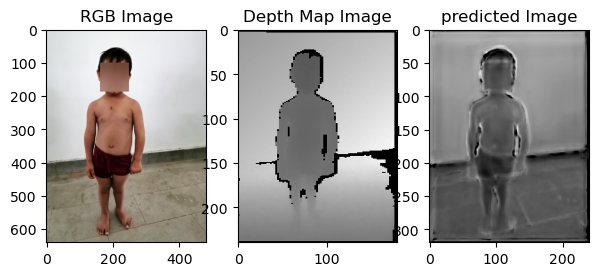

In [14]:
plt.figure(figsize=(7,15))
plt.subplot(1,3,1)
plt.title("RGB Image")
plt.imshow(data[8])

plt.subplot(1,3,2)
plt.title("Depth Map Image")
plt.imshow(np.asarray(data[3],dtype=np.float32),cmap='gray')

plt.subplot(1,3,3)
plt.title("predicted Image")
plt.imshow(predicted_image,cmap='gray')


### Inference Using Hugging Face Depth Models 

In [15]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import torch
import numpy as np
checkpoint = "vinvino02/glpn-nyu"

image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = AutoModelForDepthEstimation.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [16]:
pixel_values = image_processor(data[8], return_tensors="pt").pixel_values
with torch.no_grad():
    outputs = model(pixel_values)
    predicted_depth = outputs.predicted_depth

In [17]:
# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=(240,320),
    mode="bicubic",
    align_corners=False,
).squeeze()
output = prediction.numpy()
formatted = (output*255/ np.max(output)).astype(np.float32)

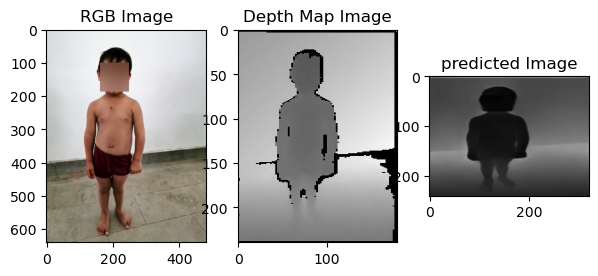

In [18]:
plt.figure(figsize=(7,15))
plt.subplot(1,3,1)
plt.title("RGB Image")
plt.imshow(data[8])

plt.subplot(1,3,2)
plt.title("Depth Map Image")
plt.imshow(np.asarray(data[3],dtype=np.float32),cmap='gray')

plt.subplot(1,3,3)
plt.title("predicted Image")

plt.imshow(formatted,cmap='gray')